In [1]:
from pathlib import Path

import numpy as np

from philipsSipVolumeParser import ScParams, readSIPscVDBParams

In [2]:
rfPath = Path("/Volumes/CREST Data/David_S_Data/Cori_Data/SHC/SHC-P002-V02-CE02_18.56.39_mf_sip_capture_50_2_1_0.raw")
scParamPath = Path("/Volumes/CREST Data/David_S_Data/Cori_Data/SHC/SHC-P002-V02-CE02_18.56.39_vdbDump.xml_Extras.txt")

In [3]:
nonLinSample=2; nonLinThr=3.5e4; nonLinDiv=1.7e4
linSample=1; linThr=3e4; linDiv=3e4
stpSample=2

scParams: ScParams = readSIPscVDBParams(scParamPath)
numPlanes = scParams.NUM_PLANES
p0 = round(numPlanes/2)

Reading SIP scan conversion VDB Params...
Finished reading SIP scan converstion VDB params...


In [4]:
paramLen = 5
params = np.fromfile(rfPath, dtype=np.int32, count=paramLen)
numSamples = params[0]/2 # assumes 2 bytes per sample
numLines = params[1]
numPixels = numSamples * numLines
AZ_XBR_OUT = params[3]
EL_ML = params[4]

In [5]:
numSamples, numLines, numPixels, AZ_XBR_OUT, EL_ML

(np.float64(1016.0),
 np.int32(216),
 np.float64(219456.0),
 np.int32(8),
 np.int32(1))

In [6]:
buffer = np.fromfile(rfPath, dtype=np.uint16, count=-1)

In [7]:
paramOffs = 2*paramLen
numSlices = buffer.size / (numPixels + paramOffs)
numVolumes = np.floor(numSlices / numPlanes)

In [34]:
out = np.zeros((int(numSamples), numLines, int(numVolumes)))

In [35]:
numSamples = int(numSamples); numLines = int(numLines)
numPixels = int(numPixels); numVolumes = int(numVolumes)
for v in range(numVolumes):
    offs = (numPixels + paramOffs) * numPlanes * v + (numPixels + paramOffs) * (p0-1) + paramOffs
    offs = int(offs)
    out[:,:,v] = buffer[offs:offs+numPixels].reshape((numSamples, numLines), order='F')

In [32]:
from tqdm import tqdm
import gc
numSamples = int(numSamples); numLines = int(numLines)
numPixels = int(numPixels); numVolumes = int(numVolumes)
planeSize = numPixels + paramOffs
for v in tqdm(range(numVolumes)):
    offs = (planeSize*numPlanes*v) + paramOffs
    for p in range(numPlanes):
        offs += p*planeSize
        out[:,:,p,v] = buffer[offs:offs+numPixels].reshape((numSamples, numLines), order='F')
    gc.collect()

  0%|          | 1/346 [00:37<3:38:17, 37.97s/it]


KeyboardInterrupt: 

In [37]:
nonLinOut = out[np.arange(nonLinSample-1, out.shape[0], stpSample)]

In [38]:
nonLinOut[:10,0,0]

array([  2.,   1.,   2.,   2.,   2.,   0.,  80.,   0., 464.,   0.])

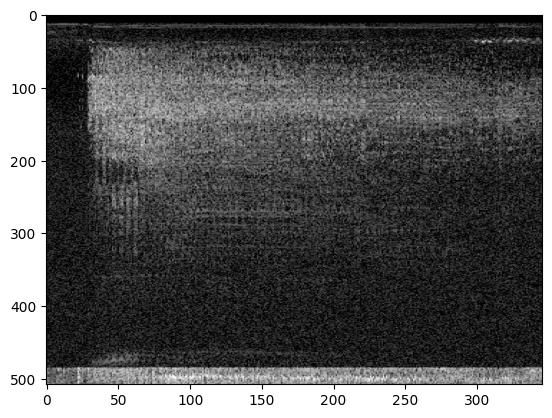

In [28]:
import matplotlib.pyplot as plt

im = (np.squeeze(nonLinOut[:,round(numLines/2),:])-nonLinThr)*255/nonLinDiv
im = np.clip(im, 0, 255)

plt.imshow(im, cmap='gray', aspect='auto')

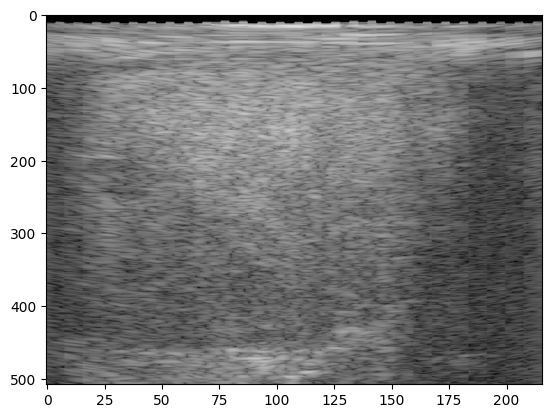

In [25]:
plt.imshow((nonLinOut[:,:,100]-linThr)*255/linDiv, vmin=0, vmax=255, cmap="gray", aspect='auto')

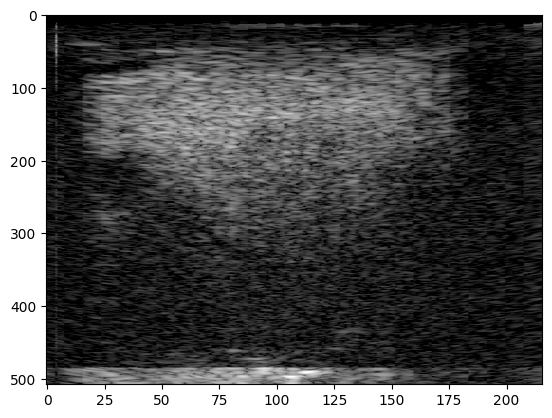

In [39]:
plt.imshow((nonLinOut[:,:,100]-nonLinThr)*255/nonLinDiv, vmin=0, vmax=255, cmap="gray", aspect='auto')

In [43]:
from pyquantus.parse.transforms import scanConvert

bmode = (nonLinOut[:,:,100]-nonLinThr)*255/nonLinDiv
bmode = np.clip(bmode, 0, 255)

scOut = scanConvert(bmode, 70, 0, 0, 1.610358750000000e+02)

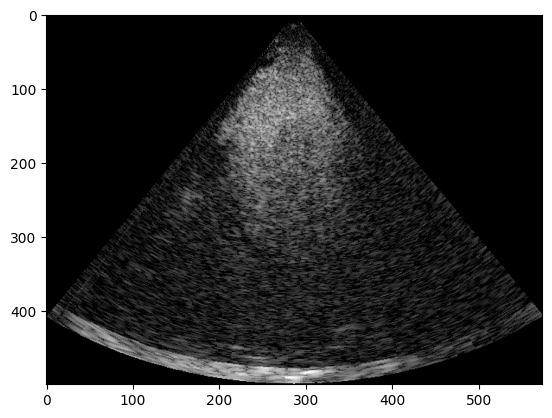

In [44]:
plt.imshow(scOut[0].scArr, cmap='gray', aspect='auto')

In [ ]:
def parseRF(rfPath: Path, scParamPath: Path) -> Rfdata:
    # From Thanasis
    nonLinSample=2; nonLinThr=3.5e4; nonLinDiv=1.7e4
    linSample=1; linThr=3e4; linDiv=3e4
    stpSample=2
    
    scParams: ScParams = readSIPscVDBParams(scParamPath)
    numPlanes = scParams.NUM_PLANES
    p0 = round(numPlanes/2)
    paramLen = 5
    params = np.fromfile(rfPath, dtype=np.int32, count=paramLen)
    numSamples = int(params[0]/stpSample)
    numLines = int(params[1])
    numPixels = numSamples * numLines
    AZ_XBR_OUT = int(params[3])
    EL_ML = int(params[4])
    
    buffer = np.fromfile(rfPath, dtype=np.uint16, count=-1)
    paramOffs = 2*paramLen
    numSlices = int(buffer.size / (numPixels + paramOffs))
    numVolumes = np.floor(numSlices / numPlanes)
    
    out = np.zeros((numSamples, numLines, numPlanes))
    for v in range(numVolumes):
        offs = (numPixels + paramOffs) * numPlanes * v + (numPixels + paramOffs) * (p0-1) + paramOffs
        offs = int(offs)
        out[:,:,v] = buffer[offs:offs+numPixels].reshape((numSamples, numLines), order='F')
        
    nonLinOut = out[np.arange(nonLinSample-1, out.shape[0], stpSample)] # most likely contrast
    linOut = out[np.arange(nonLinSample-1, out.shape[0], stpSample)] # most likely B-mode
    
    return nonLinOut, linOut, AZ_XBR_OUT, EL_ML